In [1]:
import nrrd
import numpy as np
from utils import imshow

# readdata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation.seg.nrrd')
labeldata_load, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image_load, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

In [16]:
image = image_load
labeldata = labeldata_load
print(image.shape)
print(labeldata.shape)
# imshow(image)
# imshow(labeldata)

image = np.swapaxes(image, 0, 2)
labeldata = np.swapaxes(labeldata, 0, 2)
print(image.shape)
print(labeldata.shape)

(512, 512, 265)
(512, 512, 265)
(265, 512, 512)
(265, 512, 512)


In [17]:

lbl = labeldata[[132],...] #takes one slice of the 265
print(lbl.shape)
# imshow(lbl)

print(lbl)
np.any(lbl)

# right now for the labels, the area containing the tumor is represented by 1s; every other pixel is 0
# do we need to make the labels for each slice binary in [0, 1]?  or do we keep the labels for each slice
# as a 2d array containing 0s and 1s?

(1, 512, 512)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


True

In [18]:


#add the fourth dimension (modality) which is just 1
image = np.expand_dims(image, axis=3)
labeldata = np.expand_dims(labeldata, axis=3)

print(image.shape)
print(labeldata.shape)
# imshow(image)
# imshow(labeldata)

(265, 512, 512, 1)
(265, 512, 512, 1)


(1, 512, 512, 1)
(1, 512, 512, 1)


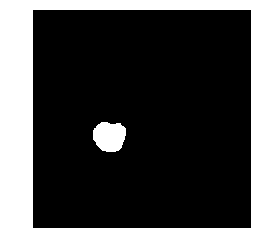

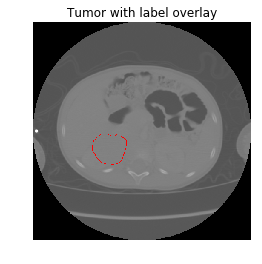

In [19]:
lbl = labeldata[[132],...] #takes one slice of the 265
img = image[[132],...] #takes one slice of the 265

print(img.shape)
print(lbl.shape)

# imshow(img)
imshow(lbl)
imshow(dat=img, lbl=lbl, title='Tumor with label overlay')

In [20]:
import tensorflow as tf


print(type(img))
print(img.shape)


X = tf.placeholder(tf.float32, [None, 512, 512, 1])

conv = tf.layers.conv2d(X, filters=8, kernel_size=(3, 3), padding='same')
relu = tf.nn.relu(conv)
pool = tf.layers.max_pooling2d(relu, pool_size=(2, 2), strides=(2, 2))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

output = sess.run(pool, feed_dict={X: img})

print(output.shape)

<class 'numpy.ndarray'>
(1, 512, 512, 1)
(1, 256, 256, 8)


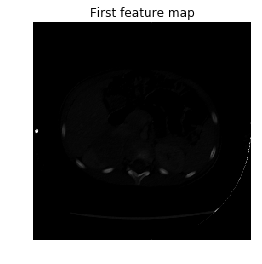

In [21]:
imshow(output[..., 0], title='First feature map')


In [22]:
sess.close()


In [226]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 512, 512, 1], name='X')
y = tf.placeholder(tf.int32, shape=[None], name='y')
mode = tf.placeholder(tf.bool, name='mode')

In [227]:
pred = create_classifier2(X, training=mode)
print(pred.shape)
print(pred)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=pred)

X:  (?, 512, 512, 1)
pool1:  (?, 256, 256, 8)
pool2:  (?, 128, 128, 16)
pool3:  (?, 64, 64, 32)
pool4:  (?, 32, 32, 64)
pool5:  (?, 16, 16, 96)
pool6:  (?, 8, 8, 128)
pool6:  (?, 1, 1, 8192)
(?, 2)
Tensor("Flatten/flatten/Reshape:0", shape=(?, 2), dtype=float32)


In [228]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
print(lbl.shape)

(1, 512, 512, 1)


(1, 512, 512, 1)
(1, 512, 512, 1)
REAL (tumor, y/n?): y
PRED (tumor, y/n?): n
LOSS (lower value is better prediction): 3.592324


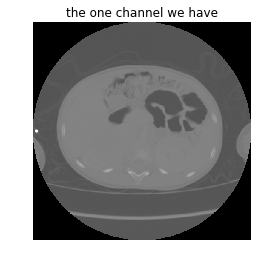

[1]


In [229]:
# dat, lbl = data.load(mode='train', n=1)
print(img.shape)
print(lbl.shape)
lbl = np.max(lbl > 0, axis=(1,2,3)).astype('int32')
sce, logits = sess.run([loss, pred], {X: img, y: lbl, mode: True})

print('REAL (tumor, y/n?): %s' % ('y' if lbl else 'n'))
print('PRED (tumor, y/n?): %s' % ('y' if logits[0, 1] > logits[0, 0] else 'n'))
print('LOSS (lower value is better prediction): %f' % sce)

imshow(img[..., 0], title='the one channel we have')
print(lbl)

In [230]:
sess.close()

In [231]:
# taken from: https://www.tensorflow.org/tutorials/estimators/cnn
print("new section")

new section


In [232]:
labeldata_load, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image_load, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

In [242]:
def create_classifier(input_layer): 
    # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=8,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv1: ", conv1.shape)
  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
  print("pool1: ", pool1.shape)


   # Convolutional Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=16,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv2: ", conv2.shape)
  # Pooling Layer #2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
  print("pool2: ", pool2.shape)


   # Convolutional Layer #3
  conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv3: ", conv3.shape)
  # Pooling Layer #3
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
  print("pool3: ", pool3.shape)


   # Convolutional Layer #4
  conv4 = tf.layers.conv2d(
      inputs=pool3,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv4: ", conv4.shape)
  # Pooling Layer #4
  pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
  print("pool4: ", pool4.shape)


   # Convolutional Layer #5
  conv5 = tf.layers.conv2d(
      inputs=pool4,
      filters=96,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv5: ", conv5.shape)
  # Pooling Layer #5
  pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[2, 2], strides=2)
  print("pool5: ", pool5.shape)


   # Convolutional Layer #6
  conv6 = tf.layers.conv2d(
      inputs=pool5,
      filters=128,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv6: ", conv6.shape)
  # Pooling Layer #6
  pool6 = tf.layers.max_pooling2d(inputs=conv6, pool_size=[2, 2], strides=2)
  print("pool6: ", pool6.shape)

    
   # Dense Layer
  pool6_flat = tf.reshape(pool6, [-1, 8 * 8 * 128])
  print("pool 6 flat: ", pool6_flat.shape)
    
  dense = tf.layers.dense(inputs=pool6_flat, units=1024, activation=tf.nn.relu)
  print("dense: ", dense.shape)
    
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.1, training=mode == tf.estimator.ModeKeys.TRAIN)
  print("dropout: ", dropout.shape)
  
  output = dropout
  return output

In [243]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
    
  print("*********\n\n\n\n*********")
  print(features)
  print(features["x"])
  print(labels)
  print(mode)

  input_layer = tf.reshape(features["x"], [-1, 512, 512, 1])
  print(input_layer)
  print(input_layer.shape)

  output = create_classifier(input_layer)
    
    
  logits = tf.layers.dense(inputs=output, units=2)
  print("***********\n\n\n\n***********")
  print("logits")
  print(logits.shape)
  print(logits)
    
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.00001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [244]:
image = image_load
labeldata = labeldata_load

labeldata = np.swapaxes(labeldata, 0, 2)

print(image.shape)
print(labeldata.shape)
# imshow(image)
# imshow(labeldata)

(512, 512, 265)
(265, 512, 512)


In [245]:
lbl_arr = np.zeros(265)
for idx, lbl_slice in enumerate(labeldata):
#     print(idx, np.any(lbl_slice))
    lbl_arr[idx] = int(np.any(lbl_slice))

In [246]:
# for idx, n in enumerate(lbl_arr):
#     print(idx, n)

image = image.reshape(-1, image.shape[-1])
image = np.swapaxes(image, 0, 1)

In [247]:
train_data = image.astype('float32')
train_labels = lbl_arr.astype('int32')
print(train_data.shape)

print(train_labels.shape)
print(type(train_labels[0]))

(265, 262144)
(265,)
<class 'numpy.int32'>


In [248]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="neuro_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'neuro_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x134dfa5c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [249]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [250]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=1,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=4,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
*********



*********
{'x': <tf.Tensor 'random_shuffle_queue_DequeueMany:1' shape=(1, 262144) dtype=float32>}
Tensor("random_shuffle_queue_DequeueMany:1", shape=(1, 262144), dtype=float32, device=/device:CPU:0)
Tensor("random_shuffle_queue_DequeueMany:2", shape=(1,), dtype=int32, device=/device:CPU:0)
train
Tensor("Reshape:0", shape=(1, 512, 512, 1), dtype=float32)
(1, 512, 512, 1)
conv1:  (1, 512, 512, 8)
pool1:  (1, 256, 256, 8)
conv2:  (1, 256, 256, 16)
pool2:  (1, 128, 128, 16)
conv3:  (1, 128, 128, 32)
pool3:  (1, 64, 64, 32)
conv4:  (1, 64, 64, 64)
pool4:  (1, 32, 32, 64)
conv5:  (1, 32, 32, 96)
pool5:  (1, 16, 16, 96)
conv6:  (1, 16, 16, 128)
pool6:  (1, 8, 8, 128)
pool 6 flat:  (1, 8192)
dense:  (1, 1024)
dropout:  (1, 1024)
***********



***********
logits
(1, 2)
Tensor("dense_1/BiasAdd:0", shape=(1, 2), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO

In [ ]:
# seems like after a while, the probabilities become NaN's; need to fix

In [ ]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)